In [2]:
# NYC Property Data Exploration
from pymongo import MongoClient
import random
import pandas as pd

# Load the dataset
file_path = 'data/NY_House_Dataset.csv'
df = pd.read_csv(file_path)



# Display the first few rows
df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [3]:
# Load your original DataFrame if not already loaded

# Select the columns you want to retain
columns_to_keep = ['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'SUBLOCALITY', 'LATITUDE', 'LONGITUDE']
cleaned_df = df[columns_to_keep].copy()

# Handle division by zero by replacing 0 with NaN
cleaned_df['BEDS'].replace(0, pd.NA, inplace=True)
cleaned_df['PROPERTYSQFT'].replace(0, pd.NA, inplace=True)

# Calculate PRICE_PER_BED and PRICE_PER_PROPERTYSQFT
cleaned_df['PRICE_PER_BED'] = cleaned_df['PRICE'] / cleaned_df['BEDS']
cleaned_df['PRICE_PER_PROPERTYSQFT'] = cleaned_df['PRICE'] / cleaned_df['PROPERTYSQFT']

# Define the path for the new CSV file
csv_filename = 'data/filtered_property_data.csv'

# Save the DataFrame to a CSV file
cleaned_df.to_csv(csv_filename, index=False)

# Preview the cleaned dataset to ensure it looks correct
cleaned_df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,SUBLOCALITY,LATITUDE,LONGITUDE,PRICE_PER_BED,PRICE_PER_PROPERTYSQFT
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,Manhattan,40.761255,-73.974483,1.575000e+05,225.000000
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,New York County,40.766393,-73.980991,2.785714e+07,11114.277572
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,Richmond County,40.541805,-74.196109,6.500000e+04,129.032258
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,New York County,40.761398,-73.974613,2.300000e+04,155.056180
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,New York County,40.767224,-73.969856,7.857143e+06,3880.070547


Data has been successfully inserted into MongoDB with geospatial indexing.
Metrics within 2500 meters of (-73.931822, 40.697359): Average price: $1673757.29 Average price per bed: $475885.07 Average price per square foot: $732.14


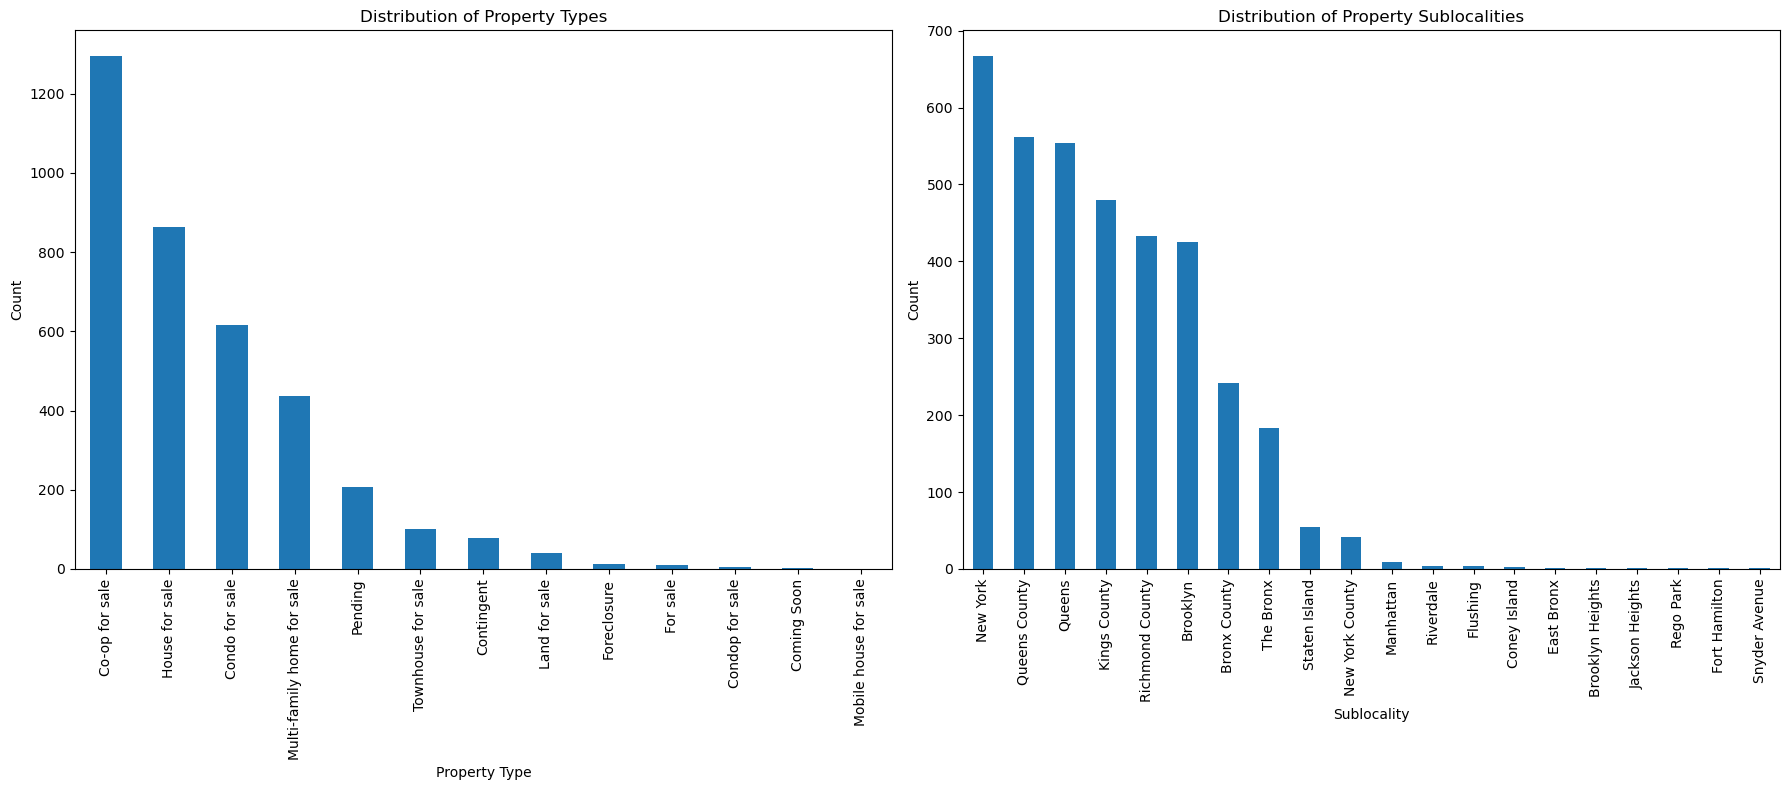

Original data size: 4801
Filtered data size after combined filtering: 3669


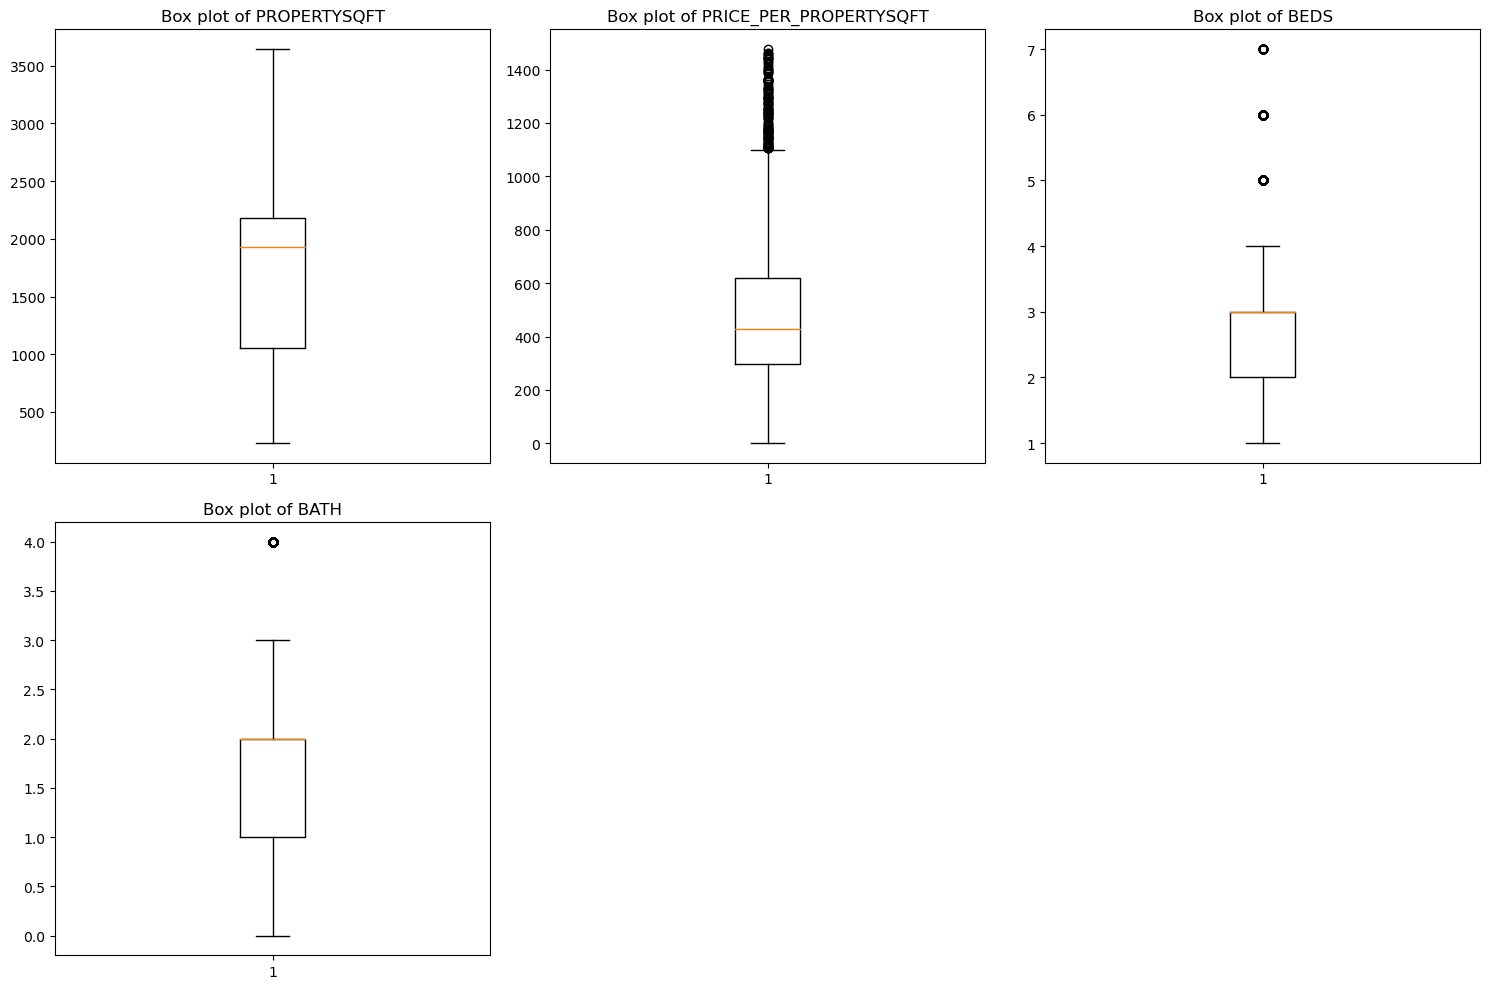

Mean Squared Error: 37569.81268669333
R-squared: 0.5402892611280379
Intercept: 382.76346450690676


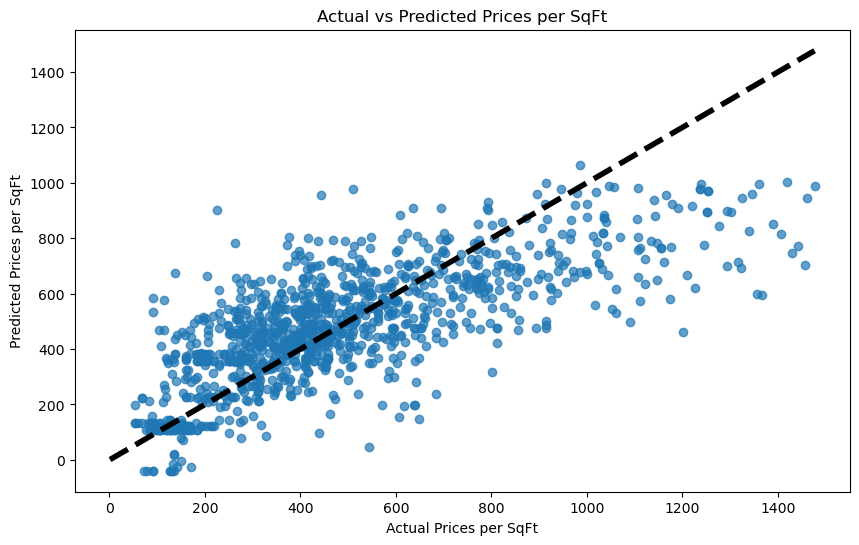

In [33]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('data/filtered_property_data.csv')

# IQR first, then Z-Score: This order is generally more robust, 
# as it allows you to first eliminate the most extreme outliers (which could skew the data) 
# before fine-tuning the outlier removal with z-score filtering. 
# This can lead to a cleaner, more reliable dataset.

# Function to remove outliers from individual columns using IQR
def remove_outliers_iqr_columnwise(df, columns):
    filtered_df = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Filter out the outliers for the current column
        filtered_df = filtered_df[~((filtered_df[column] < (Q1 - 1.5 * IQR)) | 
                                    (filtered_df[column] > (Q3 + 1.5 * IQR)))]
    return filtered_df

# Remove outliers from the relevant columns using IQR
filtered_data_columnwise = remove_outliers_iqr_columnwise(data, ['PROPERTYSQFT',  'PRICE_PER_PROPERTYSQFT', 'BEDS', 'BATH'])

# Apply z-score filtering
z_scores = np.abs(stats.zscore(filtered_data_columnwise[['PROPERTYSQFT',  'PRICE_PER_PROPERTYSQFT', 'BEDS', 'BATH']]))
threshold = 3
filtered_data_zscore = filtered_data_columnwise[(z_scores < threshold).all(axis=1)]

# Apply price threshold filtering on the already z-score filtered data
price_threshold = 2000000
final_filtered_data = filtered_data_zscore[filtered_data_zscore['PRICE'] <= price_threshold]

# Plot bar charts for TYPE and SUBLOCALITY before encoding
plt.figure(figsize=(18, 8))

# Bar chart for TYPE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
final_filtered_data['TYPE'].value_counts().plot(kind='bar')
plt.title('Distribution of Property Types')
plt.xlabel('Property Type')
plt.ylabel('Count')

# Bar chart for SUBLOCALITY
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
final_filtered_data['SUBLOCALITY'].value_counts().plot(kind='bar')
plt.title('Distribution of Property Sublocalities')
plt.xlabel('Sublocality')
plt.ylabel('Count')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Handle categorical variables using OneHotEncoding
categorical_features = ['TYPE', 'SUBLOCALITY']
final_filtered_data = pd.get_dummies(final_filtered_data, columns=categorical_features, drop_first=True)

# Save the final filtered data
final_filtered_data.to_csv('data/final_filtered_property_data_no_outliers.csv', index=False)

# Print the number of rows before and after filtering
print(f"Original data size: {data.shape[0]}")
print(f"Filtered data size after combined filtering: {final_filtered_data.shape[0]}")

# Render box plots separately for each column in the final filtered data
plt.figure(figsize=(15, 10))

# Box plot for PROPERTYSQFT
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st subplot
plt.boxplot(final_filtered_data['PROPERTYSQFT'])
plt.title('Box plot of PROPERTYSQFT')

# Box plot for PRICE_PER_PROPERTYSQFT
plt.subplot(2, 3, 2)  # 2 rows, 3 columns, 2nd subplot
plt.boxplot(final_filtered_data['PRICE_PER_PROPERTYSQFT'])
plt.title('Box plot of PRICE_PER_PROPERTYSQFT')

# Box plot for BEDS
plt.subplot(2, 3, 3)  # 2 rows, 3 columns, 3rd subplot
plt.boxplot(final_filtered_data['BEDS'])
plt.title('Box plot of BEDS')

# Box plot for BATH
plt.subplot(2, 3, 4)  # 2 rows, 3 columns, 4th subplot
plt.boxplot(final_filtered_data['BATH'])
plt.title('Box plot of BATH')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Run the Linear Regression after removing outliers
# Select the features (independent variables) and target (dependent variable)
features = ['PROPERTYSQFT', 'BEDS', 'BATH'] + [col for col in final_filtered_data.columns if col.startswith('TYPE_') or col.startswith('SUBLOCALITY_')]
X = final_filtered_data[features]  # Features
y = final_filtered_data['PRICE_PER_PROPERTYSQFT']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict using the trained model
y_pred = model.predict(X_test)

# Calculate Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

# Print the intercept
print(f'Intercept: {model.intercept_}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Prices per SqFt')
plt.ylabel('Predicted Prices per SqFt')
plt.title('Actual vs Predicted Prices per SqFt')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()


In [ ]:
# The latest results show a significant improvement in the 
# model's performance based on the R-squared value and the Mean Squared Error. 

# The scatter plot shows a more pronounced linear relationship between actual and predicted prices per square foot. 
# While there is still some spread around the regression line, the overall fit has improved, especially for 
# properties with a price per square foot in the middle range.

In [34]:
# Constants for MongoDB connection and geospatial calculations
MONGO_URI = 'mongodb://localhost:27017/'
DB_NAME = 'property_database'
COLLECTION_NAME = 'properties'
RADIUS_METERS = 2500

# Constants defining the geographic boundaries of NYC
LAT_MIN = 40.4774
LAT_MAX = 40.9176
LON_MIN = -74.2591
LON_MAX = -73.7004

def insert_data_into_mongodb():
    """
    Load data from CSV and insert it into MongoDB with geospatial indexing.
    """
    # Load your DataFrame if not already loaded
    df = final_filtered_data

    # Combine LATITUDE and LONGITUDE into GeoJSON format
    df['location'] = df.apply(lambda row: {'type': 'Point', 'coordinates': [row['LONGITUDE'], row['LATITUDE']]}, axis=1)

    # Convert the DataFrame to a dictionary format
    data = df.to_dict(orient='records')

    # Establish a connection to MongoDB
    client = MongoClient(MONGO_URI)

    # Specify the database and collection
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]

    # Drop the collection if it exists to start fresh (optional)
    collection.drop()

    # Insert the data into the collection
    collection.insert_many(data)

    # Create a geospatial index on the location field
    collection.create_index([('location', '2dsphere')])

    print("Data has been successfully inserted into MongoDB with geospatial indexing.")

def calculate_average_metrics(center_latitude, center_longitude, radius_meters):
    """
    Calculate the average property price, price per bed, and price per square foot within a specified radius of a given location.

    Parameters:
    center_latitude (float): Latitude of the center point.
    center_longitude (float): Longitude of the center point.
    radius_meters (float): Radius in meters within which to search for properties.

    Returns:
    dict: Average metrics of properties within the radius, or None if no properties are found.
    """
    # Establish a connection to MongoDB
    client = MongoClient(MONGO_URI)
    
    # Specify the database and collection
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]

    # Define the aggregation pipeline
    pipeline = [
        {
            '$geoNear': {
                'near': {'type': 'Point', 'coordinates': [center_longitude, center_latitude]},
                'distanceField': 'distance',
                'spherical': True,
                'maxDistance': radius_meters  # Use the radius in meters directly
            }
        },
        {
            '$group': {
                '_id': None,
                'average_price': {'$avg': '$PRICE'},
                'average_price_per_bed': {'$avg': '$PRICE_PER_BED'},
                'average_price_per_sqft': {'$avg': '$PRICE_PER_PROPERTYSQFT'}
            }
        }
    ]

    # Execute the aggregation
    result = list(collection.aggregate(pipeline))

    # Return the average metrics if result is found, else return None
    if result:
        return result[0]
    else:
        return None

# Insert data into MongoDB (this step should be done once or when data updates)
insert_data_into_mongodb()

lng = 40.697359
lat = -73.931822
metrics = calculate_average_metrics(lng, lat, RADIUS_METERS)
if metrics:
    print(f"Metrics within {RADIUS_METERS} meters of ({lat:.6f}, {lng:.6f}): Average price: ${metrics['average_price']:.2f} Average price per bed: ${metrics['average_price_per_bed']:.2f} Average price per square foot: ${metrics['average_price_per_sqft']:.2f}")
else:
    print(f"No properties found within {RADIUS_METERS} meters of ({lat:.6f}, {lng:.6f}).")


Data has been successfully inserted into MongoDB with geospatial indexing.
Metrics within 2500 meters of (-73.931822, 40.697359): Average price: $1052268.22 Average price per bed: $402698.81 Average price per square foot: $714.33
